In [1]:
import sys
import pandas as pd
import numpy as np
import math
from scipy.spatial.distance import cosine
import xml.etree.ElementTree as ET
import pickle
import re
import itertools

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn import svm, linear_model, cross_validation
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier

c:\python35\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def transform_pairwise(X, y):
    """Transforms data into pairs with balanced labels for ranking
    Transforms a n-class ranking problem into a two-class classification
    problem. Subclasses implementing particular strategies for choosing
    pairs should override this method.
    In this method, all pairs are choosen, except for those that have the
    same target value. The output is an array of balanced classes, i.e.
    there are the same number of -1 as +1
    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,) or (n_samples, 2)
        Target labels. If it's a 2D array, the second column represents
        the grouping of samples, i.e., samples with different groups will
        not be considered.
    Returns
    -------
    X_trans : array, shape (k, n_feaures)
        Data as pairs
    y_trans : array, shape (k,)
        Output class labels, where classes have values {-1, +1}
    """
    X_new = []
    y_new = []
    y = np.asarray(y)
    if y.ndim == 1:
        y = np.c_[y, np.ones(y.shape[0])]
    comb = itertools.combinations(range(X.shape[0]), 2)
    for k, (i, j) in enumerate(comb):
        if y[i, 0] == y[j, 0] or y[i, 1] != y[j, 1]:
            # skip if same target or different group
            continue
        X_new.append(X[i] - X[j])
        y_new.append(np.sign(y[i, 0] - y[j, 0]))
        # output balanced classes
        if y_new[-1] != (-1) ** k:
            y_new[-1] = - y_new[-1]
            X_new[-1] = - X_new[-1]
    return np.asarray(X_new), np.asarray(y_new).ravel()


In [9]:
class RankSVM(svm.LinearSVC):
    """Performs pairwise ranking with an underlying LinearSVC model
    Input should be a n-class ranking problem, this object will convert it
    into a two-class classification problem, a setting known as
    `pairwise ranking`.
    See object :ref:`svm.LinearSVC` for a full description of parameters.
    """
    
    def fit(self, X, y):
        """
        Fit a pairwise ranking model.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,) or (n_samples, 2)
        Returns
        -------
        self
        """
        X_trans, y_trans = transform_pairwise(X, y)
        super(RankSVM, self).fit(X_trans, y_trans)
        return self

    def decision_function(self, X):
        return np.dot(X, self.coef_.ravel())

    def predict(self, X):
        """
        Predict an ordering on X. For a list of n samples, this method
        returns a list from 0 to n-1 with the relative order of the rows of X.
        The item is given such that items ranked on top have are
        predicted a higher ordering (i.e. 0 means is the last item
        and n_samples would be the item ranked on top).
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        Returns
        -------
        ord : array, shape (n_samples,)
            Returns a list of integers representing the relative order of
            the rows in X.
        """
        if hasattr(self, 'coef_'):
            return np.argsort(np.dot(X, self.coef_.ravel()))
        else:
            raise ValueError("Must call fit() prior to predict()")

    def score(self, X, y):
        """
        Because we transformed into a pairwise problem, chance level is at 0.5
        """
        X_trans, y_trans = transform_pairwise(X, y)
        return np.mean(super(RankSVM, self).predict(X_trans) == y_trans)


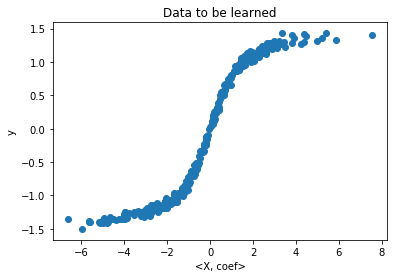

Performance of ranking  0.986440677966
Performance of ranking  0.978787878788
Performance of linear regression  0.958757062147


In [13]:
np.random.seed(1)
n_samples, n_features = 300, 5
true_coef = np.random.randn(n_features)
X = np.random.randn(n_samples, n_features)
noise = np.random.randn(n_samples) / np.linalg.norm(true_coef)
y = np.dot(X, true_coef)
y = np.arctan(y) # add non-linearities
y += .1 * noise  # add noise
Y = np.c_[y, np.mod(np.arange(n_samples), 5)]  # add query fake id
cv = cross_validation.KFold(n_samples, 5)
train, test = next(iter(cv))

# make a simple plot out of it
import pylab as pl
pl.scatter(np.dot(X, true_coef), y)
pl.title('Data to be learned')
pl.xlabel('<X, coef>')
pl.ylabel('y')
pl.show()

# print the performance of ranking
rank_svm = RankSVM().fit(X[train], Y[train])


X_train_trans, y_train_trans = transform_pairwise(X[test], y[test])
X_test_trans, y_test_trans = transform_pairwise(X[test], y[test])
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf.fit(X_train_trans, y_train_trans)
print('Performance of ranking ', clf.score(X_test_trans, y_test_trans))
print('Performance of ranking ', rank_svm.score(X[test], Y[test]))

# and that of linear regression
ridge = linear_model.RidgeCV(fit_intercept=True)
ridge.fit(X[train], y[train])
X_test_trans, y_test_trans = transform_pairwise(X[test], y[test])
score = np.mean(np.sign(np.dot(X_test_trans, ridge.coef_)) == y_test_trans)
print('Performance of linear regression ', score)

In [15]:
rank_svm.coef_.ravel()

array([ 2.10224037, -0.83604315, -0.71212664, -1.43457554,  1.1286637 ])

In [ ]:
train_dataset.loc[201570]

In [ ]:
def readXML(path):
    """
    Read XML file into a dictionary
    """
    tree = ET.parse(path)
    root = tree.getroot()
    
    dataset = pd.DataFrame(columns=['QID', 'QAID'], dtype=int)
    
    for Question in root:
        QID = int(Question.get('QID'))
        Qtext = Question.find('Qtext').text
        
        for QApair in Question.iter('QApair'): 
            QAID = int(QApair.get('QAID'))
            QArel = QApair.get('QArel')
            QAconf = QApair.get('QAconf')
            QAquestion = QApair.find('QAquestion').text
            QAanswer = QApair.find('QAanswer').text
            
            dataset = dataset.append({'QID': QID,
                                    'QAID': QAID,
                                    'Qtext': Qtext,
                                    'QAquestion': QAquestion,
                                    'QAanswer': QAanswer,
                                    'QArel': 0 if QArel == 'I' else 1,
                                    'QAconf': QAconf}, ignore_index=True)
            
    dataset.set_index(['QID', 'QAID'], inplace=True)
    return dataset

In [ ]:
train_dataset = readXML('../TRAIN/SemEval2016-Task3-CQA-MD-train.xml')
test_dataset = readXML('../TEST/2017/SemEval2017-Task3-CQA-MD-test.xml')

train_dataset = train_dataset.sort_index(level=0, ascending=[False, True])
train_dataset = train_dataset.reset_index().drop_duplicates().set_index(['QID', 'QAID'])

test_dataset = test_dataset.sort_index(level=0, ascending=[False, True])
test_dataset = test_dataset.reset_index().drop_duplicates().set_index(['QID', 'QAID'])

In [ ]:
from nltk import wordpunct_tokenize
from nltk.stem import ISRIStemmer

class StemTokenizer(object):
    def __init__(self):
        self.wnl = ISRIStemmer()
    def __call__(self, doc):
         return [self.wnl.stem(t) for t in wordpunct_tokenize(doc)]

In [ ]:
train_lsa = Pipeline([('tfidf', TfidfVectorizer(min_df=1, max_df=0.1, tokenizer=StemTokenizer(), stop_words=stopwords.words('arabic'), smooth_idf=False, sublinear_tf=True, norm='l2', max_features=1000)),
                      ('lsa',  TruncatedSVD(n_components=900,n_iter=3)),
                      ('normalizer', Normalizer(copy=False))])
train_lsa.fit(list(set(train_dataset['Qtext'])))

test_lsa = Pipeline([('tfidf', TfidfVectorizer(min_df=1, max_df=0.1, tokenizer=StemTokenizer(), stop_words=stopwords.words('arabic'), smooth_idf=False, sublinear_tf=True, norm='l2', max_features=1000)),
                ('normalizer', Normalizer(copy=False))])
test_lsa.fit(list(set(test_dataset['Qtext'])))

In [ ]:
train_query_vec = train_lsa.transform(train_dataset['Qtext'])
train_question_vec = train_lsa.transform(train_dataset['QAquestion'] + train_dataset['QAanswer'])

In [ ]:
X_train = train_question_vec
Y_train = np.c_[train_dataset['QAconf'].astype(np.float), train_dataset.reset_index()['QID']]

X_valid = X_train[int(X_train.shape[0] * 0.8):]
Y_valid = Y_train[int(Y_train.shape[0] * 0.8):]

X_train = X_train[:int(X_train.shape[0] * 0.8)]
Y_train = Y_train[:int(Y_train.shape[0] * 0.8)]

In [ ]:
# print the performance of ranking
rank_svm = RankSVM().fit(X_train, Y_train)
print('Performance of ranking ', rank_svm.score(X_valid, Y_valid))

In [ ]:
rankings = []
for QID, data in test_dataset.groupby(level=0):
    test_query_vec = test_lsa.transform(data['Qtext'])
    test_question_vec = test_lsa.transform(data['QAquestion'] + data['QAanswer'])
    X_test = test_question_vec
    # print the performance of ranking
    ranking = rank_svm.predict(X_test.toarray())
    rankings.append(1+ranking)

In [ ]:
ranking_list = []
for ranking in rankings:
    for rank in ranking:
        ranking_list.append(rank)

In [ ]:
test_query_vec = test_lsa.transform(test_dataset['Qtext'])
test_question_vec = test_lsa.transform(test_dataset['QAquestion'] + test_dataset['QAanswer'])

similarities = [1 - cosine(query.reshape(-1, 1), question.reshape(-1, 1)) for query, question in zip(test_query_vec, test_question_vec)]


In [ ]:
test_dataset['Score'] = similarities
test_dataset['Relevance'] = ['true' if similarity > 0.5 else 'false' for similarity in similarities]
test_dataset['Rank'] = 0

In [ ]:
test_dataset.shape

In [ ]:
def MAP(gold_dataset, pred_dataset, th=10):
    dataset = pred_dataset.join(gold_dataset, lsuffix='_pred', rsuffix='_gold')[['Score_pred', 'Relevance_gold']].reset_index()
    dataset = dataset.sort_values(['QID', 'Score_pred'], ascending=False)
    dataset['Rank_pred'] = dataset.groupby('QID')['Score_pred'].rank(ascending=False)
    dataset = dataset[dataset.Relevance_gold]
    dataset = dataset[dataset.Rank_pred <= th]
    dataset['Position'] = dataset.groupby('QID')['Rank_pred'].rank(ascending=True)
    dataset['Precision'] = dataset.Position / dataset.Rank_pred
    AP = dataset.groupby('QID')['Precision'].mean()
    return round(AP.sum() / len(pred_dataset.groupby('QID')),4) * 100

In [ ]:
gold_dataset = pd.read_csv('../EVAL/SemEval2017-Task3-CQA-MD-test.xml.subtaskD.relevancy', sep='\t',  names=['QID', 'QAID', 'Rank', 'Score', 'Relevance'], index_col=['QID', 'QAID'])

In [ ]:
MAP(gold_dataset, test_dataset) 

In [ ]:
train_dataset['']

In [ ]:
Y[train]